In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import os
import airportsdata 
from geopy.distance import geodesic

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pycountry
import pycountry_convert as pc
import plotly.io as pio
import seaborn as sns


# 1. Data Preparation

In [44]:
path_flights = os.getcwd() + '/data/data_flight_economy_business.xlsx'

data_all = pd.read_excel(path_flights,sheet_name='combined')
data_direct = pd.read_excel(path_flights,sheet_name='direct')
data_non_direct = pd.read_excel(path_flights,sheet_name='non_direct')

airports = airportsdata.load()

In [45]:
data_all.iloc[:3]

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,Split Econ/Busi,Seats Economy,Seats Business,total_kg_co2,pp_kg_co2
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,574.385162,0.560376,0.011436,0.128205,36,5,3.172736e+05,71.960449
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,143944.442097,140.433602,2.865992,0.098361,385,42,1.315651e+07,1731.575913
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,64061.196967,62.498729,1.275484,0.180672,195,43,4.811404e+06,1382.587424


In [46]:
data_all.dropna(subset=['Seats Economy', 'Seats Business'], inplace=True)

# Convert 'Seats Economy' and 'Seats Business' to integers
data_all['Seats Economy'] = data_all['Seats Economy'].astype(int)
data_all['Seats Business'] = data_all['Seats Business'].astype(int)

data_all['Seats Economy'] = data_all['Seats Economy'] * data_all['assumed_load_factor']
data_all['Seats Business'] = data_all['Seats Business'] * data_all['assumed_load_factor']


Get latitude and longitude for origin and destination

In [47]:
def get_coordinates(row, column_name):
    airport_code = row[column_name]
    airport_info = airports.get(airport_code)
    if airport_info:
        return pd.Series([airport_info['lat'], airport_info['lon']])
    else:
        print("airport miss")
        return pd.Series([None, None])

# Apply the function to get latitude and longitude for origin and destination airports
data_all[['origin_lat', 'origin_lon']] = data_all.apply(lambda row: get_coordinates(row, 'origin_airport'), axis=1)
data_all[['dest_lat', 'dest_lon']] = data_all.apply(lambda row: get_coordinates(row, 'destination_airport'), axis=1)


airport miss
airport miss
airport miss
airport miss
airport miss


In [48]:
# four misses 
data_all.iloc[:3]

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,...,sulphates_kg,Split Econ/Busi,Seats Economy,Seats Business,total_kg_co2,pp_kg_co2,origin_lat,origin_lon,dest_lat,dest_lon
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,...,0.011436,0.128205,19.076264,2.649481,3.172736e+05,71.960449,24.433001,54.651100,25.2528,55.364399
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,...,2.865992,0.098361,303.146625,33.070541,1.315651e+07,1731.575913,-23.435556,-46.473057,25.2528,55.364399
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,...,1.275484,0.180672,125.061780,27.577726,4.811404e+06,1382.587424,40.080101,116.584999,25.2528,55.364399


Calculate distance between origin and destination

In [49]:
def calculate_distance(row):
    origin_coord = (row['origin_lat'], row['origin_lon'])
    dest_coord = (row['dest_lat'], row['dest_lon'])
    return geodesic(origin_coord, dest_coord).kilometers

# Drop rows with NaN values in latitude and longitude columns
data_all.dropna(subset=['origin_lat', 'origin_lon', 'dest_lat', 'dest_lon'], inplace=True)

# Apply the function to calculate distances
data_all['distance_km'] = data_all.apply(calculate_distance, axis=1)

data_all#.iloc[:3]

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,...,Split Econ/Busi,Seats Economy,Seats Business,total_kg_co2,pp_kg_co2,origin_lat,origin_lon,dest_lat,dest_lon,distance_km
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,...,0.128205,19.076264,2.649481,3.172736e+05,71.960449,24.433001,54.651100,25.252800,55.364399,115.950338
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,...,0.098361,303.146625,33.070541,1.315651e+07,1731.575913,-23.435556,-46.473057,25.252800,55.364399,12217.959202
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,...,0.180672,125.061780,27.577726,4.811404e+06,1382.587424,40.080101,116.584999,25.252800,55.364399,5855.097793
3,WIII,1229,OMDB,0.637657,B77W,52290.480217,165185.627004,1076.737713,7.272460,1.045810,...,0.098361,245.497785,26.781577,9.508812e+05,773.703171,-6.125570,106.655998,25.252800,55.364399,6543.696070
4,RJTT,1221,OMDB,0.645028,B77L,72779.497786,229910.433506,1418.160959,7.370945,1.455590,...,0.180672,125.780525,27.736218,5.083146e+06,1932.020450,35.552299,139.779999,25.252800,55.364399,7949.313707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,LEBL,0,LEBL,0.698774,B77W,42317.352958,133680.517994,869.466243,6.217029,0.846347,...,0.098361,187.970160,20.264441,8.971847e+02,0.000000,41.297100,2.078460,41.297100,2.078460,0.000000
272,FKKD,233,HRYR,0.609583,B737,6736.739545,21281.360222,66.971578,0.858806,0.134735,...,0.000000,70.102009,0.000000,1.336823e+03,966.712591,4.006080,9.719480,-1.968630,30.139500,2365.873445
273,HRYR,0,HRYR,0.606079,A332,26776.622897,84587.351733,374.152490,2.358692,0.535532,...,0.065972,98.790932,7.272952,9.667126e+02,0.000000,-1.968630,30.139500,-1.968630,30.139500,0.000000
274,ZMCK,133,RKSI,0.637657,B738,6254.043886,19756.524635,66.628216,0.506219,0.125081,...,0.103896,56.113779,6.376566,2.094095e+03,1690.900178,47.646667,106.820000,37.469101,126.450996,1959.939864


In [50]:
dubai_airport = pd.DataFrame({'dest_lat_A': [airports.get('OMDB')['lat']],
                     'origin_lon_A': [airports.get('OMDB')['lon']]})

delegate_airports = data_all[['dest_lat','origin_lon']]

# Function to calculate distance using geopy.distance
def calculate_distance(row):
    coord_A = (dubai_airport['dest_lat_A'].iloc[0], dubai_airport['origin_lon_A'].iloc[0])
    coord_B = (row['dest_lat'], row['origin_lon'])
    return geodesic(coord_A, coord_B).kilometers

data_all.loc[data_all['origin_airport'] == data_all['destination_airport'], 'distance_km'] = delegate_airports.apply(calculate_distance,axis=1).astype(np.int64)
data_all.iloc[:3]

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,...,Split Econ/Busi,Seats Economy,Seats Business,total_kg_co2,pp_kg_co2,origin_lat,origin_lon,dest_lat,dest_lon,distance_km
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,...,0.128205,19.076264,2.649481,3.172736e+05,71.960449,24.433001,54.651100,25.2528,55.364399,115.950338
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,...,0.098361,303.146625,33.070541,1.315651e+07,1731.575913,-23.435556,-46.473057,25.2528,55.364399,12217.959202
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,...,0.180672,125.061780,27.577726,4.811404e+06,1382.587424,40.080101,116.584999,25.2528,55.364399,5855.097793


In [51]:
factor_business = 4.025

data_all['total_seats'] = data_all['Seats Economy'] + data_all['Seats Business'] 
data_all['total_seats_factor_business'] = (data_all['Seats Economy'] + data_all['Seats Business'] * factor_business)

data_all['economy_co2_pp'] = (data_all['co2_kg'] * data_all['Seats Economy'] / data_all['total_seats_factor_business']) / data_all['Seats Economy']
data_all['business_co2_pp'] = (data_all['co2_kg'] * data_all['Seats Business'] * factor_business /  data_all['total_seats_factor_business']) / data_all['Seats Business']

In [52]:
data_all.columns#aircraft_type_icao.unique()

Index(['origin_airport', 'total_delegates', 'destination_airport',
       'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn',
       'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg',
       'sulphates_kg', 'Split Econ/Busi', 'Seats Economy', 'Seats Business',
       'total_kg_co2', 'pp_kg_co2', 'origin_lat', 'origin_lon', 'dest_lat',
       'dest_lon', 'distance_km', 'total_seats', 'total_seats_factor_business',
       'economy_co2_pp', 'business_co2_pp'],
      dtype='object')

In [53]:
# Assuming data_all is your DataFrame containing the relevant columns

# Count occurrences of each aircraft type before grouping
occurrences = data_all['aircraft_type_icao'].value_counts().reset_index()
occurrences.columns = ['aircraft_type_icao', 'occurrences']

# Grouping by aircraft_type_icao and calculating the average of other columns
grouped_data = data_all.groupby('aircraft_type_icao').agg({
    'total_seats': lambda x: round(x.mean(), 1),
    'distance_km': lambda x: round(x.mean(), 1),
    'total_fuel_burn': lambda x: round(x.mean(), 1)
}).reset_index()

# Merge the occurrences information with grouped_data
grouped_data = pd.merge(grouped_data, occurrences, on='aircraft_type_icao', how='left')

print(grouped_data)

   aircraft_type_icao  total_seats  distance_km  total_fuel_burn  occurrences
0                A20N         80.8       2338.7           5729.6            3
1                A21N        102.0       2576.2           8190.8            4
2                A310        128.0        874.5           5839.9            1
3                A319         69.5       1494.0           4740.8            6
4                A320         78.3       1904.2           4761.9           10
5                A321         86.4       2252.1           8192.1            5
6                A332        131.3       3336.4          22308.5           10
7                A333         91.1       1988.3          13425.3            7
8                A359        160.0       2723.9          19312.9            3
9                A388        380.8       6993.1          93130.2            8
10               AT72         32.1        286.2            519.4            1
11               AT75         33.5        101.0            298.9

In [54]:
# Definitely long haul : A359, A388, B77L, B77W, B788,
short_medium_aircraft = ['A20N','A21N','B38M','B734','B748','B752','B763','BCS3','DC87','E190','RJ85','E290','B733',]
short_haul_aircraft = ['A310','A319','A320','A321','A333','A359','AT72','AT76','AT75','B735','B737','B738','B744','B737','E190','B762','CRJ2','D228','DH8D','E145','E170',
                       'A20N','A21N','B734','B752','B763','DC87','RJ85']

# Define a function to check if the aircraft_type_icao is in the short_haul_aircraft list
def is_short_haul(aircraft_type):
    return aircraft_type in short_haul_aircraft

# Apply the function to create a new column 'is_short_haul'
grouped_data['is_short_haul'] = grouped_data['aircraft_type_icao'].apply(is_short_haul)
data_all['is_short_haul'] = data_all['aircraft_type_icao'].apply(is_short_haul)

In [55]:
# data_all[data_all['is_short_haul'] == True]
# grouped_data[grouped_data['is_short_haul'] == True]

In [61]:
import pandas as pd

# Assuming data_all is your DataFrame
# Replace 'total_delegates' with your actual value column name

# Track the count of occurrences for each reference value
occurrence_count = {}

# Replace zeros in the value column with the nth occurrence value for each reference value
for index, row in data_all.iterrows():
    if row['total_delegates'] == 0:
        reference_value = row['destination_airport']
        if reference_value not in occurrence_count:
            occurrence_count[reference_value] = 0
        else:
            occurrence_count[reference_value] += 1
        nth_occurrence = occurrence_count[reference_value]
        replacement_value = data_all[data_all['destination_airport'] == reference_value]['total_delegates'].iloc[nth_occurrence]
        data_all.at[index, 'total_delegates'] = replacement_value


In [63]:
file_path = os.path.join('output', 'test_total_delegates.xlsx')
data_all.to_excel(file_path, index=False)

In [23]:
data_all['total_delegates'].sum()

118958

## 1.1 Calculating CO2 Emission
### 1.1.1 With load factor
Calculating the co2 emissions for economy and business class

In [14]:
data_all[['Seats Economy', 'Seats Business','total_seats_factor_business', 'economy_co2_pp', 'business_co2_pp']]

,Seats Economy,Seats Business,total_seats_factor_business,economy_co2_pp,business_co2_pp
0,19.076264,2.649481,29.740426,49.602155,199.648675
1,303.146625,33.070541,436.255553,847.419488,3410.863441
2,125.061780,27.577726,236.062126,696.968660,2805.298855
3,245.497785,26.781577,353.293630,467.559030,1881.925096
4,125.780525,27.736218,237.418805,968.374994,3897.709350
...,...,...,...,...,...
273,187.970160,20.264441,269.534535,495.968051,1996.271406
274,70.102009,0.000000,70.102009,303.577037,NaN
275,98.790932,7.272952,128.064565,660.505519,2658.534715
276,56.113779,6.376566,81.779457,241.582977,972.371482


## 1.2 Long and short haul flights

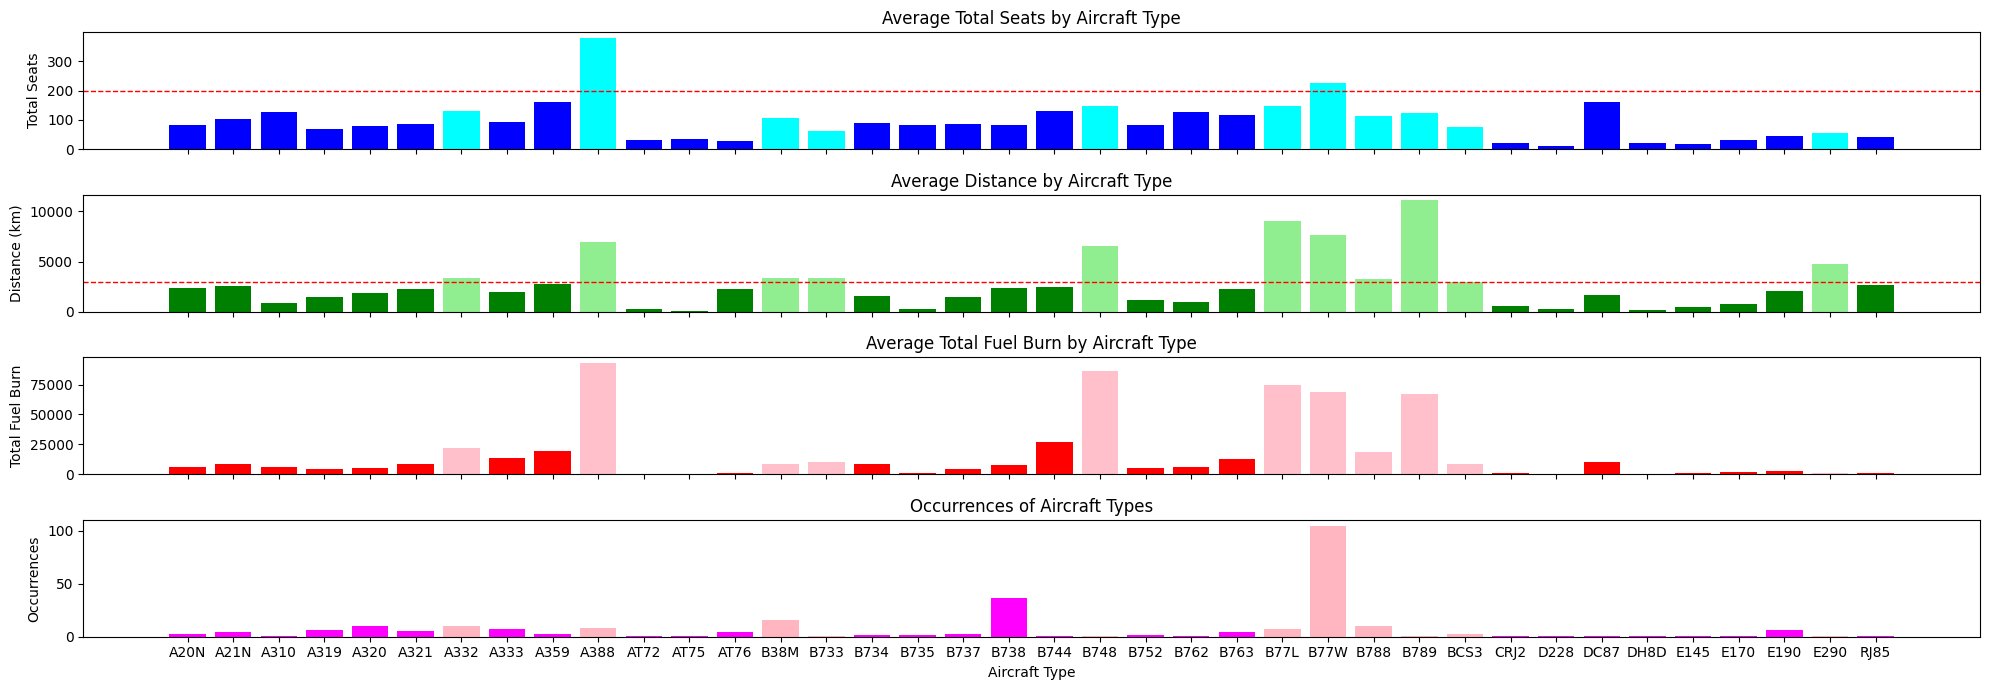

In [15]:
# Create a figure with subplots
fig, axs = plt.subplots(4, 1, figsize=(20, 7),sharex=True)


# Plotting total seats
for index, row in grouped_data.iterrows():
    color = 'cyan' if row['aircraft_type_icao'] not in short_haul_aircraft else 'blue'
    axs[0].bar(row['aircraft_type_icao'], row['total_seats'], color=color)

axs[0].set_title('Average Total Seats by Aircraft Type')
# axs[0].set_xlabel('Aircraft Type')
axs[0].set_ylabel('Total Seats')
axs[0].axhline(y=200, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 200


# Plotting distance
for index, row in grouped_data.iterrows():
    color = 'lightgreen' if row['aircraft_type_icao'] not in short_haul_aircraft else 'green'
    axs[1].bar(row['aircraft_type_icao'], row['distance_km'], color=color)

axs[1].set_title('Average Distance by Aircraft Type')
# axs[1].set_xlabel('Aircraft Type')
axs[1].set_ylabel('Distance (km)')
axs[1].axhline(y=3000, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 3000


# Plotting total fuel burn
for index, row in grouped_data.iterrows():
    color = 'pink' if row['aircraft_type_icao'] not in short_haul_aircraft else 'red'
    axs[2].bar(row['aircraft_type_icao'], row['total_fuel_burn'], color=color)

axs[2].set_title('Average Total Fuel Burn by Aircraft Type')
# axs[2].set_xlabel('Aircraft Type')
axs[2].set_ylabel('Total Fuel Burn')

# Plotting occurrences
for index, row in grouped_data.iterrows():
    color = 'LIGHTPINK' if row['aircraft_type_icao'] not in short_haul_aircraft else 'magenta'
    axs[3].bar(row['aircraft_type_icao'], row['occurrences'], color=color)

axs[3].set_title('Occurrences of Aircraft Types')
axs[3].set_xlabel('Aircraft Type')
axs[3].set_ylabel('Occurrences')
axs[3].tick_params(axis='x', which='both', bottom=True, top=False)  # Show x-axis ticks only for axs[3]


# Rotate x-axis labels for better readability if necessary
# plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# 2. Data Analysis
## 2.1 General

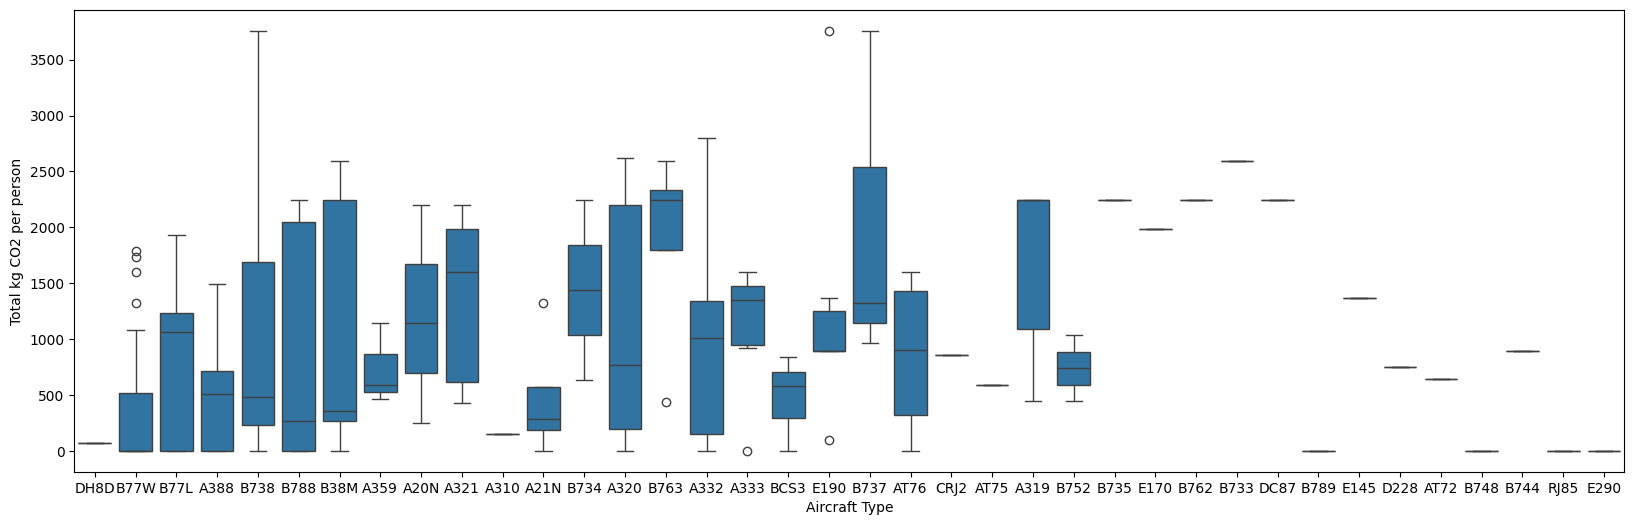

In [137]:
# Boxplot for total_fuel_burn
plt.figure(figsize=(20, 6))
sns.boxplot(x='aircraft_type_icao', y='pp_kg_co2', data=data_all)
# plt.title('Total kg of CO2 per person')
plt.xlabel('Aircraft Type')
plt.ylabel('Total kg CO2 per person')
plt.show()

# # Boxplot for total_fuel_burn
# plt.figure(figsize=(15, 6))
# sns.boxplot(x='aircraft_type_icao', y='pp_g_co2_km', data=data_all)
# # plt.title('Total kg of CO2 per person')
# plt.xlabel('Aircraft Type')
# plt.ylabel('Total g CO2 per km')
# plt.show()

In [131]:
# plt.figure(figsize=(15, 6))

# # Barplot for average value
# sns.barplot(x='aircraft_type_icao', y='pp_g_co2_km', data=data_direct, estimator=lambda x: sum(x) / len(x), color='lightblue')

# # Add values to the top of the bars
# for p in plt.gca().patches:
#     plt.gca().annotate('{:.2f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
#                 textcoords='offset points')

# plt.xlabel('Aircraft Type')
# plt.ylabel('Total g CO2 per km')

# plt.show()


## 2.2 Split Economy/Business Class

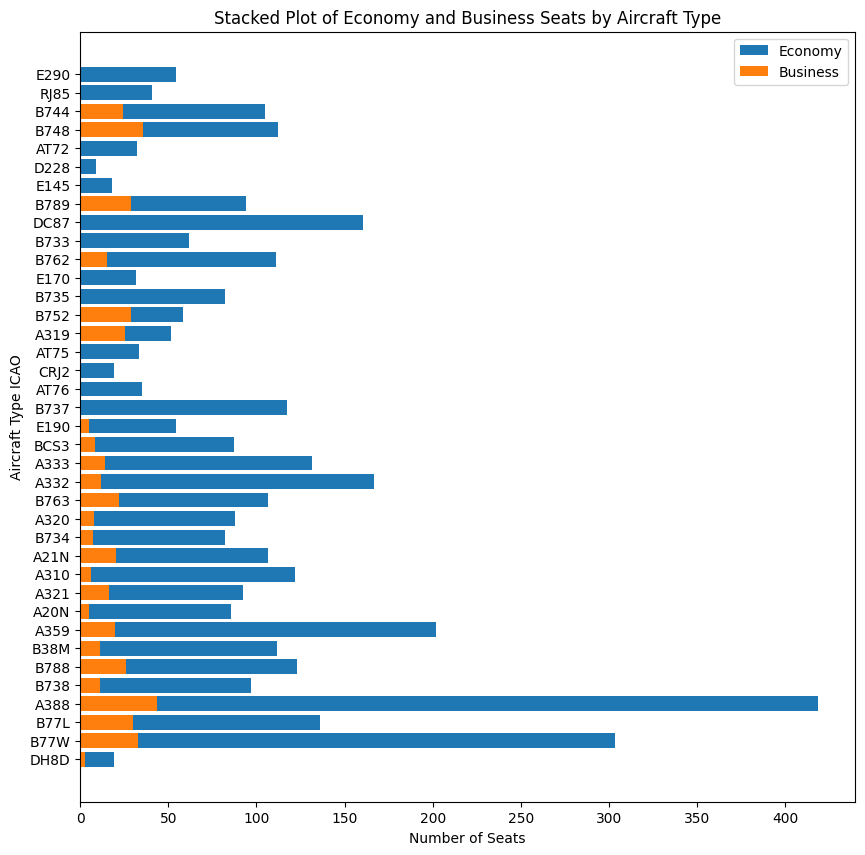

In [142]:

# Plot
plt.figure(figsize=(10, 10))

# Stacked bar plot
plt.barh(data_all['aircraft_type_icao'], data_all['Seats Economy'], label='Economy')
plt.barh(data_all['aircraft_type_icao'], data_all['Seats Business'], left=data_all['Seats Economy'], label='Business')

# Labels and title
plt.xlabel('Number of Seats')
plt.ylabel('Aircraft Type ICAO')
plt.title('Stacked Plot of Economy and Business Seats by Aircraft Type')
plt.legend()

# Show plot
plt.show()


### 2.2.1 CO2 Emission Visualisation

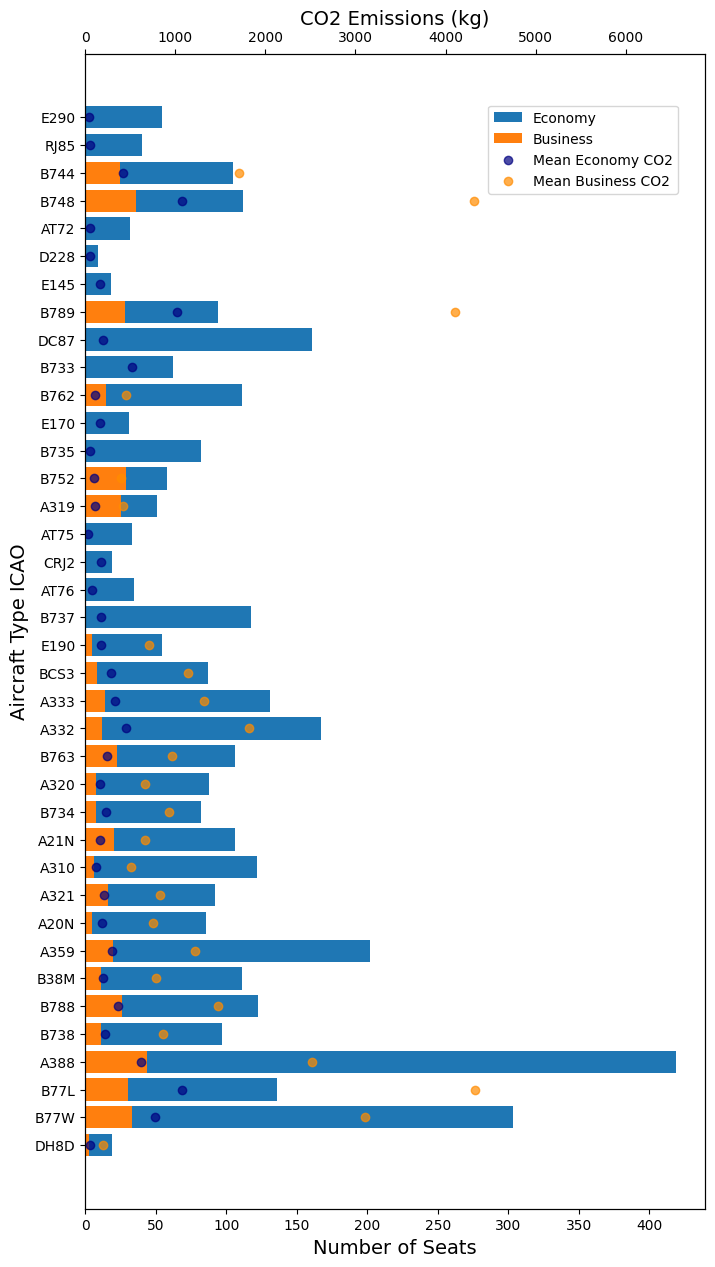

In [148]:
# Calculate mean CO2 emissions for business and economy
mean_business_co2 = data_all.groupby('aircraft_type_icao')['business_co2_pp'].mean()
mean_economy_co2 = data_all.groupby('aircraft_type_icao')['economy_co2_pp'].mean()

# Plot
fig, ax1 = plt.subplots(figsize=(8, 15))

# Stacked bar plot for seats
ax1.barh(data_all['aircraft_type_icao'], data_all['Seats Economy'], label='Economy')
ax1.barh(data_all['aircraft_type_icao'], data_all['Seats Business'], label='Business')

# Labels and title for seats
ax1.set_xlabel('Number of Seats', fontsize=14)
ax1.set_ylabel('Aircraft Type ICAO', fontsize=14)
# ax1.set_title('Stacked Plot of Economy and Business Seats by Aircraft Type', fontsize=16)

# Create a second x-axis for CO2 emissions
ax2 = ax1.twiny()
ax2.set_xlabel('CO2 Emissions (kg)', fontsize=14)

ax2.set_xlim(0, data_all[['business_co2_pp', 'economy_co2_pp']].max().max() + 100)

# Plot mean CO2 emissions as points with darker shades
ax2.scatter(mean_economy_co2, mean_economy_co2.index, color='navy', label='Mean Economy CO2', alpha=0.7)
ax2.scatter(mean_business_co2, mean_business_co2.index, color='darkorange', label='Mean Business CO2', alpha=0.7)

# Add legend
# fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
# ax1.legend(loc='upper right', bbox_to_anchor=(1, 1.2))
fig.legend(loc='upper right', bbox_to_anchor=(0.875, 0.85))

# Show plot
plt.show()


# 3 Calculating total emissions

In [17]:
data_all['total_co2'] = (data_all['total_delegates'] / (data_all['Seats Business'] + data_all['Seats Economy'])) * data_all['co2_kg'] * 2 # two directions
data_all#.iloc[:3]

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,...,origin_lon,dest_lat,dest_lon,distance_km,total_seats,total_seats_factor_business,economy_co2_pp,business_co2_pp,is_short_haul,total_co2
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,...,54.651100,25.252800,55.364399,115.950338,21.725745,29.740426,49.602155,199.648675,True,1.193148e+06
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,...,-46.473057,25.252800,55.364399,12217.959202,336.217166,436.255553,847.419488,3410.863441,False,7.956427e+06
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,...,116.584999,25.252800,55.364399,5855.097793,152.639505,236.062126,696.968660,2805.298855,False,5.691235e+06
3,WIII,1229,OMDB,0.637657,B77W,52290.480217,165185.627004,1076.737713,7.272460,1.045810,...,106.655998,25.252800,55.364399,6543.696070,272.279361,353.293630,467.559030,1881.925096,False,1.491212e+06
4,RJTT,1221,OMDB,0.645028,B77L,72779.497786,229910.433506,1418.160959,7.370945,1.455590,...,139.779999,25.252800,55.364399,7949.313707,153.516744,237.418805,968.374994,3897.709350,False,3.657199e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,LEBL,0,LEBL,0.698774,B77W,42317.352958,133680.517994,869.466243,6.217029,0.846347,...,2.078460,41.297100,2.078460,5183.000000,208.234601,269.534535,495.968051,1996.271406,False,0.000000e+00
274,FKKD,233,HRYR,0.609583,B737,6736.739545,21281.360222,66.971578,0.858806,0.134735,...,9.719480,-1.968630,30.139500,2365.873445,70.102009,70.102009,303.577037,NaN,True,1.414669e+05
275,HRYR,0,HRYR,0.606079,A332,26776.622897,84587.351733,374.152490,2.358692,0.535532,...,30.139500,-1.968630,30.139500,4058.000000,106.063885,128.064565,660.505519,2658.534715,False,0.000000e+00
276,ZMCK,133,RKSI,0.637657,B738,6254.043886,19756.524635,66.628216,0.506219,0.125081,...,106.820000,37.469101,126.450996,1959.939864,62.490345,81.779457,241.582977,972.371482,True,8.409676e+04
